In [7]:
import math

class Node:
    def __init__(self, key):
        self.key = key
        self.parent = None
        self.child = None
        self.left = self
        self.right = self
        self.degree = 0
        self.mark = False

class FibonacciHeap:
    def __init__(self):
        self.min_node = None
        self.total_nodes = 0

    def insert(self, key):
        node = Node(key)
        self._merge_with_root_list(node)
        if self.min_node is None or node.key < self.min_node.key:
            self.min_node = node
        self.total_nodes += 1
        return node

    def find_min(self):
        return self.min_node.key if self.min_node else None

    def union(self, other_heap):
        if other_heap.min_node is None:
            return
        if self.min_node is None:
            self.min_node = other_heap.min_node
            self.total_nodes = other_heap.total_nodes
            return
        # Concatenate root lists
        self.min_node.right.left = other_heap.min_node.left
        other_heap.min_node.left.right = self.min_node.right
        self.min_node.right = other_heap.min_node
        other_heap.min_node.left = self.min_node
        # Update min pointer
        if other_heap.min_node.key < self.min_node.key:
            self.min_node = other_heap.min_node
        self.total_nodes += other_heap.total_nodes

    def extract_min(self):
        z = self.min_node
        if z is not None:
            # Add children of z to root list
            if z.child is not None:
                children = [x for x in self._iterate(z.child)]
                for child in children:
                    self._merge_with_root_list(child)
                    child.parent = None
            # Remove z from root list
            self._remove_from_root_list(z)
            if z == z.right:
                self.min_node = None
            else:
                self.min_node = z.right
                self._consolidate()
            self.total_nodes -= 1
            return z.key
        return None

    def decrease_key(self, x, k):
        if k > x.key:
            raise ValueError("New key is greater than current key")
        x.key = k
        y = x.parent
        if y is not None and x.key < y.key:
            self._cut(x, y)
            self._cascading_cut(y)
        if x.key < self.min_node.key:
            self.min_node = x

    def delete(self, x):
        self.decrease_key(x, float('-inf'))
        self.extract_min()

    # Internal helper methods

    def _merge_with_root_list(self, node):
        if self.min_node is None:
            node.left = node.right = node
            self.min_node = node
        else:
            node.left = self.min_node
            node.right = self.min_node.right
            self.min_node.right.left = node
            self.min_node.right = node

    def _remove_from_root_list(self, node):
        node.left.right = node.right
        node.right.left = node.left

    def _iterate(self, head):
        node = stop = head
        flag = False
        while True:
            if node == stop and flag:
                break
            elif node == stop:
                flag = True
            yield node
            node = node.right

    def _consolidate(self):
        max_degree = int(math.log(self.total_nodes) * 1.44) + 1 if self.total_nodes > 0 else 0
        A = [None] * max_degree

        nodes = [x for x in self._iterate(self.min_node)]
        for w in nodes:
            x = w
            d = x.degree
            while A[d] is not None:
                y = A[d]
                if x.key > y.key:
                    x, y = y, x
                self._link(y, x)
                A[d] = None
                d += 1
            A[d] = x

        self.min_node = None
        for i in range(max_degree):
            if A[i] is not None:
                if self.min_node is None or A[i].key < self.min_node.key:
                    self.min_node = A[i]

    def _link(self, y, x):
        # Remove y from root list
        self._remove_from_root_list(y)
        # Make y a child of x
        y.left = y.right = y
        if x.child is None:
            x.child = y
        else:
            y.right = x.child.right
            y.left = x.child
            x.child.right.left = y
            x.child.right = y
        y.parent = x
        x.degree += 1
        y.mark = False

    def _cut(self, x, y):
        # Remove x from child list of y
        if y.child == x:
            if x.right != x:
                y.child = x.right
            else:
                y.child = None
        x.left.right = x.right
        x.right.left = x.left
        y.degree -= 1
        # Add x to root list
        self._merge_with_root_list(x)
        x.parent = None
        x.mark = False

    def _cascading_cut(self, y):
        z = y.parent
        if z is not None:
            if not y.mark:
                y.mark = True
            else:
                self._cut(y, z)
                self._cascading_cut(z)


Running Fibonacci Heap benchmark...
Running Binary Heap benchmark...
Fibonacci Heap times: Insert=0.0464s, Decrease-Key=0.0012s, Extract-Min=0.0188s
Binary Heap times: Insert=0.0051s, Decrease-Key=0.0008s, Extract-Min=0.0003s


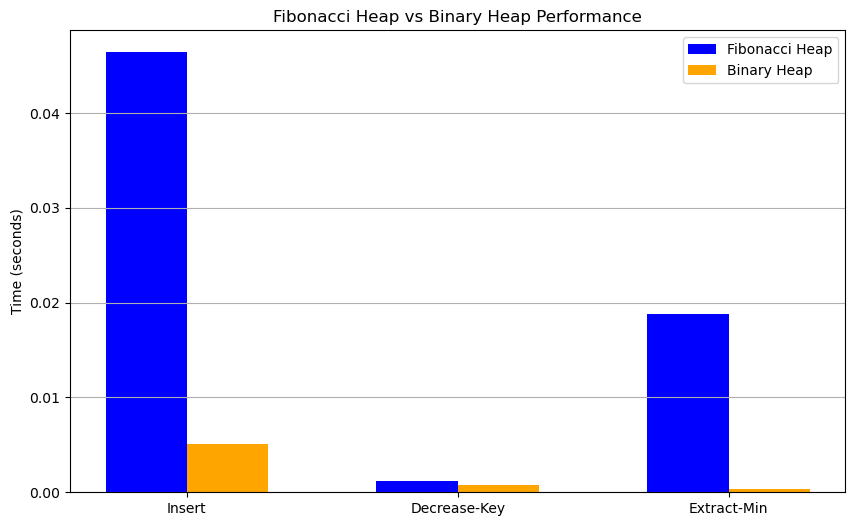

In [8]:
import time
import random
import heapq
import matplotlib.pyplot as plt

def benchmark_fibonacci_heap(fib, num_ops=10000):
    nodes = []
    insert_times = []
    decrease_key_times = []
    extract_min_times = []

    # Insert benchmark
    start = time.time()
    for _ in range(num_ops):
        key = random.randint(1, 10**6)
        nodes.append(fib.insert(key))
    insert_times.append(time.time() - start)

    # Decrease-key benchmark (10% of insertions)
    start = time.time()
    for _ in range(num_ops // 10):
        node = random.choice(nodes)
        new_key = node.key - random.randint(1, 1000)
        if new_key < node.key:
            fib.decrease_key(node, new_key)
    decrease_key_times.append(time.time() - start)

    # Extract-min benchmark (10% of insertions)
    start = time.time()
    for _ in range(num_ops // 10):
        fib.extract_min()
    extract_min_times.append(time.time() - start)

    return insert_times[0], decrease_key_times[0], extract_min_times[0]

def benchmark_binary_heap(num_ops=10000):
    bh = []
    insert_times = []
    decrease_key_times = []
    extract_min_times = []

    # Insert benchmark
    start = time.time()
    for _ in range(num_ops):
        key = random.randint(1, 10**6)
        heapq.heappush(bh, key)
    insert_times.append(time.time() - start)

    # Decrease-key benchmark (simulate by pop + push smaller key)
    start = time.time()
    for _ in range(num_ops // 10):
        if bh:
            key = heapq.heappop(bh)
            new_key = key - random.randint(1, 1000)
            heapq.heappush(bh, new_key)
    decrease_key_times.append(time.time() - start)

    # Extract-min benchmark
    start = time.time()
    for _ in range(num_ops // 10):
        if bh:
            heapq.heappop(bh)
    extract_min_times.append(time.time() - start)

    return insert_times[0], decrease_key_times[0], extract_min_times[0]

def plot_results(fib_times, bin_times):
    operations = ['Insert', 'Decrease-Key', 'Extract-Min']
    x = range(len(operations))

    plt.figure(figsize=(10,6))
    plt.bar([i - 0.15 for i in x], fib_times, width=0.3, label='Fibonacci Heap', color='blue')
    plt.bar([i + 0.15 for i in x], bin_times, width=0.3, label='Binary Heap', color='orange')
    plt.xticks(x, operations)
    plt.ylabel('Time (seconds)')
    plt.title('Fibonacci Heap vs Binary Heap Performance')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

if __name__ == "__main__":
    num_operations = 10000
    fib_heap = FibonacciHeap()

    print("Running Fibonacci Heap benchmark...")
    fib_insert, fib_decrease, fib_extract = benchmark_fibonacci_heap(fib_heap, num_operations)

    print("Running Binary Heap benchmark...")
    bin_insert, bin_decrease, bin_extract = benchmark_binary_heap(num_operations)

    fib_times = [fib_insert, fib_decrease, fib_extract]
    bin_times = [bin_insert, bin_decrease, bin_extract]

    print(f"Fibonacci Heap times: Insert={fib_insert:.4f}s, Decrease-Key={fib_decrease:.4f}s, Extract-Min={fib_extract:.4f}s")
    print(f"Binary Heap times: Insert={bin_insert:.4f}s, Decrease-Key={bin_decrease:.4f}s, Extract-Min={bin_extract:.4f}s")

    plot_results(fib_times, bin_times)
